# EMOTION CLASSIFICATION SPEECH PROCESSING PROJECT

### importing data

In [ ]:
# audio_song = '/kaggle/working/Audio_Song_Actors_01-24'
# audio_speech = '/kaggle/working/Audio_Speech_Actors_01-24'

# raw_audio = '/kaggle/working/raw-audio/raw_audio'

### it will combine data from both ravdess folders into one folder

In [ ]:
# no need to run again as target_folder will be provided in file folder 

import os
import shutil

def combine_all_audio_folders(source_folders, target_folder):
    os.makedirs(target_folder, exist_ok=True)

    for source in source_folders:
        for root, _, files in os.walk(source):
            for file in files:
                if file.endswith(".wav"):
                    src_path = os.path.join(root, file)
                    dest_path = os.path.join(target_folder, file)
                    shutil.copy(src_path, dest_path)
                    print(f"Copied: {file}")

source_folders = [audio_song , audio_speech]
target_folder = raw_audio

combine_all_audio_folders(source_folders, target_folder)

# XGboost (just a basic model)
### (no time series usage here)

In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### Feature extraction 
#### (MFCC, chroma and contrast)

In [33]:
import os
import librosa
import numpy as np
import pandas as pd

# --- Paths ---
raw_audio_folder = '/kaggle/input/raw-audio/raw_audio'  # Folder containing .wav files

# --- Emotion Code to Label Mapping ---
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
    '08': 'surprise'
}

# --- Data Storage ---
data = []

# --- Iterate Over Audio Files ---
for file in os.listdir(raw_audio_folder):
    if file.endswith(".wav"):
        emotion_code = file.split("-")[2]
        emotion = emotion_map.get(emotion_code)

        if emotion:
            file_path = os.path.join(raw_audio_folder, file)
            try:
                # Load audio file
                y, sr = librosa.load(file_path, sr=None)

                # Extract features
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                chroma = librosa.feature.chroma_stft(y=y, sr=sr)
                contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

                # Aggregate features (mean & std)
                features = np.hstack([
                    np.mean(mfccs, axis=1),
                    np.std(mfccs, axis=1),
                    np.mean(chroma, axis=1),
                    np.std(chroma, axis=1),
                    np.mean(contrast, axis=1),
                    np.std(contrast, axis=1)
                ])

                # Append features with emotion label
                data.append(list(features) + [emotion])

            except Exception as e:
                print(f" Error processing {file}: {e}")

# --- Define Feature Column Names ---
mfcc_names    = [f'mfcc_mean_{i+1}' for i in range(13)] + [f'mfcc_std_{i+1}' for i in range(13)]
chroma_names  = [f'chroma_mean_{i+1}' for i in range(12)] + [f'chroma_std_{i+1}' for i in range(12)]
contrast_names = [f'contrast_mean_{i+1}' for i in range(7)] + [f'contrast_std_{i+1}' for i in range(7)]

columns = mfcc_names + chroma_names + contrast_names + ['emotion']

# --- Create DataFrame and Save to CSV ---
df = pd.DataFrame(data, columns=columns)
df.to_csv('/kaggle/working/ravdess_features_full_M+S.csv', index=False)

print(" All features extracted and saved to CSV.")


/tmp/ipykernel_35/2443814765.py:24: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


 Error processing 03-02-02-01-02-02-14.wav: 
All features extracted and saved.


In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- Load extracted features ---
df = pd.read_csv('/kaggle/working/ravdess_features_full_M+S.csv')

# --- Separate features (X) and labels (y) ---
X = df.drop('emotion', axis=1).values  # Feature matrix
y = LabelEncoder().fit_transform(df['emotion'])  # Convert emotion labels to integers

# --- Split into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensures balanced label distribution
)

print(" Data loaded and split successfully.")
print(f"Train set size: {X_train.shape[0]} samples")
print(f"Test set size:  {X_test.shape[0]} samples")

## default XGB

In [37]:
# Default classifier — XGBClassifier with no custom parameters
model_xgb = xgb.XGBClassifier()

model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[60  0  4  4  6  0  0  1]
 [ 0 59  2  1  4  3  6  0]
 [ 4  2 23  1  3  0  2  4]
 [ 2  1  2 57  4  0  8  1]
 [ 4  7  0  6 52  2  2  2]
 [ 0  4  2  2  1 24  3  2]
 [ 0  8  0  5  7  3 50  2]
 [ 0  0  4  2  4  1  2 26]]
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        75
           1       0.73      0.79      0.76        75
           2       0.62      0.59      0.61        39
           3       0.73      0.76      0.75        75
           4       0.64      0.69      0.67        75
           5       0.73      0.63      0.68        38
           6       0.68      0.67      0.68        75
           7       0.68      0.67      0.68        39

    accuracy                           0.71       491
   macro avg       0.71      0.70      0.70       491
weighted avg       0.72      0.71      0.71       491



### parameter tuning for XGB

In [ ]:
# param_grid = {
#     'n_estimators': [150, 200, 250],
#     'max_depth': [5, 7, 9],                 
#     'learning_rate': [0.01, 0.05, 0.1],    
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
# }
# Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250, 'subsample': 1.0}
# accuracy 72% on test data

# param_grid = {
#     'n_estimators': [125, 175],             
#     'max_depth': [3, 5],                    
#     'learning_rate': [0.05,0.1],                
#     'subsample': [0.8,1],                      
#     'colsample_bytree': [0.8,1],               
#     'reg_alpha': [0, 0.1],                   
#     'reg_lambda': [1.0, 1.5]
# }
# # {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 175, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 1}
# accuracy 72%

# --- final fine Parameter grid for tuning ---
param_grid = {
    'n_estimators': [150, 175, 200],          # Number of trees
    'max_depth': [4, 5, 6],                   # Tree depth
    'learning_rate': [0.07, 0.1, 0.13],       # Learning rate
    'subsample': [0.9, 1.0],                  # Subsampling for rows
    'colsample_bytree': [0.7, 0.8, 0.9],      # Subsampling for columns
    'reg_alpha': [0, 0.05],                   # L1 regularization
    'reg_lambda': [1.5, 2.0]                  # L2 regularization
}

# --- Base XGBoost model ---
model = xgb.XGBClassifier(
    objective="multi:softmax",     # Multiclass classification
    num_class=8,                   # Number of emotion classes
    eval_metric="mlogloss",        # Log loss for multiclass
    use_label_encoder=False,       # Avoid warning
    random_state=42
)

# --- Grid Search CV ---
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# --- Fit model ---
grid_search.fit(X_train, y_train)

# --- Best results ---
print(" Best Parameters:", grid_search.best_params_)
print(" Best Cross-Validation Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

# --- Best model on test data ---
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# --- Evaluation ---
print("\n Classification Report on Test Data:")
print(classification_report(y_test, y_pred))

# --- Underfitting vs Overfitting check ---
y_train_pred = best_model.predict(X_train)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

print(f"\n Train Accuracy: {train_acc:.4f}")
print(f" Test Accuracy:  {test_acc:.4f}")

# Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.13, 'max_depth': 6, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 2.0, 'subsample': 0.9}
# accuracy 72%

In [ ]:
# --- Best Parameters found from Grid Search ---
best_params = {
    'objective': 'multi:softmax',      # Multiclass classification
    'num_class': 8,                    # Number of emotion classes
    'eval_metric': 'mlogloss',        # Multiclass log loss
    'random_state': 42,               # For reproducibility
    'colsample_bytree': 0.8,
    'learning_rate': 0.13,
    'max_depth': 6,
    'n_estimators': 150,
    'reg_alpha': 0,                   # L1 regularization
    'reg_lambda': 2.0,                # L2 regularization
    'subsample': 0.9                  # Row sampling
}

# --- Initialize and train the XGBoost model ---
model = xgb.XGBClassifier(**best_params)   # ** for dictionary unpacking
model.fit(X_train, y_train)

# --- Make predictions on test data ---
y_pred = model.predict(X_test)

# --- Classification report ---
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# --- Accuracy on Train and Test Sets ---
train_acc = accuracy_score(y_train, model.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)

print(f"\n Train Accuracy: {train_acc:.4f}")
print(f" Test Accuracy:  {test_acc:.4f}")

# Neural Networks


In [40]:
# all imports

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import random
import librosa
import tensorflow as tf
import json
import optuna
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, BatchNormalization,LSTM, 
                                    Bidirectional, Dropout, Dense, SpatialDropout1D)

from optuna.integration import TFKerasPruningCallback
from optuna.samplers import TPESampler



In [ ]:
! pip install -U optuna
! pip install optuna-integration[tfkeras]
! pip install optuna-integration[keras]

## Preprocessing and Feature extraction

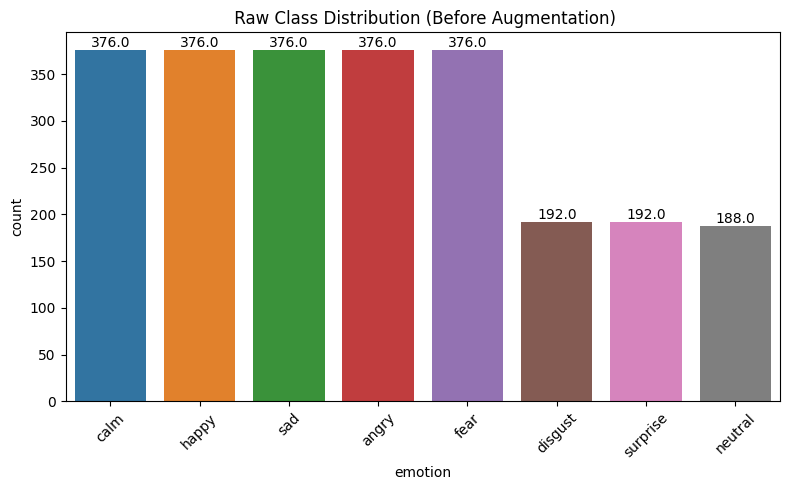

In [42]:
# --- Set constants ---
DATA_DIR = '/kaggle/input/raw-audio/raw_audio'
random.seed(42)


# --- 1. Emotion Mapping from RAVDESS file codes ---
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
    '08': 'surprise'
}


# --- 2. Collect all .wav file paths and associated emotion labels ---
file_paths = []
labels = []

for file in sorted(os.listdir(DATA_DIR)):
    if file.endswith(".wav"):
        code = file.split("-")[2]  # Extract emotion code from filename
        emotion = emotion_map.get(code)
        if emotion:
            file_paths.append(os.path.join(DATA_DIR, file))
            labels.append(emotion)


# --- 3. Encode string emotion labels to integers ---
le = LabelEncoder()
y_encoded = le.fit_transform(labels)


# --- 4. Save the LabelEncoder for future decoding ---
joblib.dump(le, "label_encoder.pkl")


# --- 5. Visualize class distribution before any augmentation ---
df_raw = pd.DataFrame({'emotion': le.inverse_transform(y_encoded)})

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='emotion', data=df_raw, order=df_raw['emotion'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')
plt.title(" Raw Class Distribution (Before Augmentation)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- 6. Train-Validation-Test Split ---
# First split into Train+Val and Test
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    file_paths, y_encoded, test_size=0.15, stratify=y_encoded, random_state=42)

# Then split Train+Val into Train and Val
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    X_train_paths, y_train, test_size=0.15 / 0.85, stratify=y_train, random_state=42)

# Now:
# - X_train_paths → 70%
# - X_val_paths   → 15%
# - X_test_paths  → 15%

/tmp/ipykernel_35/1680718846.py:57: UserWarning: PySoundFile failed. Trying audioread instead.
  y_audio, sr = librosa.load(file, sr=SR)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


 Skipping /kaggle/input/raw-audio/raw_audio/03-02-02-01-02-02-14.wav due to error: 
 MAX_LEN set to: 162


Processing:  63%|██████▎   | 232/368 [00:05<00:03, 40.90it/s]/tmp/ipykernel_35/1680718846.py:78: UserWarning: PySoundFile failed. Trying audioread instead.
  y_audio, sr = librosa.load(path, sr=SR)
Processing:  66%|██████▌   | 242/368 [00:06<00:02, 42.39it/s]

 Error with /kaggle/input/raw-audio/raw_audio/03-02-02-01-02-02-14.wav: 


Processing: 100%|██████████| 368/368 [00:09<00:00, 39.77it/s]


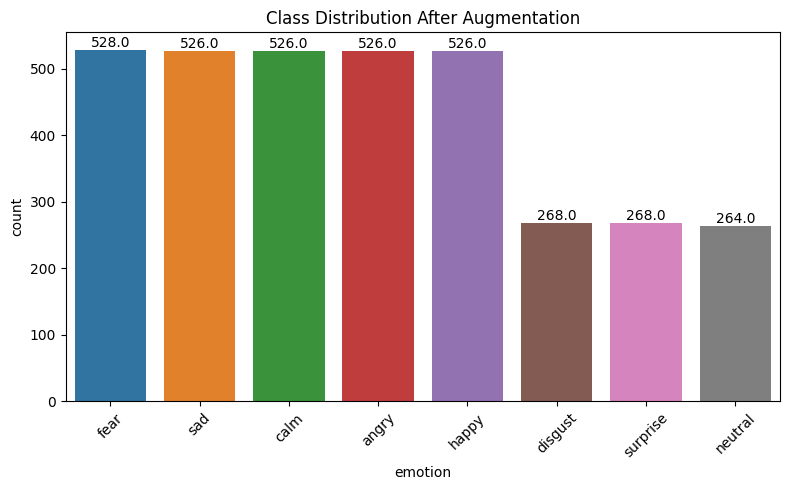

In [43]:
# 7. Setting defaults
SR = 16000
N_MFCC = 40
AUGMENT = True
USE_DELTAS = True
USE_CHROMA = True
USE_CONTRAST = True
random.seed(42)


# 8. Audio Augmentation
def add_noise(y, noise_level=0.005):
    return y + noise_level * np.random.randn(len(y))

def augment_audio(y, sr):
    ops = [
        lambda x: librosa.effects.pitch_shift(x, sr=sr, n_steps=random.uniform(-2, 2)),
        lambda x: librosa.effects.time_stretch(x, rate=random.uniform(0.9, 1.1)),
        lambda x: add_noise(x)
    ]
    n_aug = random.randint(1, 2)
    selected_ops = random.sample(ops, n_aug)
    for op in selected_ops:
        y = op(y)
    return y


# 9. Feature Extraction
def extract_features(y_audio, sr, max_len):
    mfcc = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=N_MFCC)
    features = [mfcc]

    if USE_DELTAS:
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        features.extend([delta, delta2])

    if USE_CHROMA:
        stft = np.abs(librosa.stft(y_audio))
        chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
        features.append(chroma)

    if USE_CONTRAST:
        contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
        features.append(contrast)

    stacked = np.vstack(features).T
    padded = pad_sequences([stacked], maxlen=max_len, padding='post', truncating='post', dtype='float32')[0]
    return padded


# 10. Calculating MAX_LEN using 95th percentile
lengths, valid_paths, valid_labels = [], [], []

for file, label in zip(file_paths, y_encoded):
    try:
        y_audio, sr = librosa.load(file, sr=SR)
        mfcc = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=N_MFCC)
        lengths.append(mfcc.shape[1])
        valid_paths.append(file)
        valid_labels.append(label)
    except Exception as e:
        print(f" Skipping {file} due to error: {e}")

if not lengths:
    raise RuntimeError(" No valid audio files found.")

MAX_LEN = int(np.percentile(lengths, 95))
print(f" MAX_LEN set to: {MAX_LEN}")
np.save("max_len.npy", MAX_LEN)


# 11. Process Data with or without Augmentation
def process_set(paths, y_values, augment=False):
    X_out, y_out = [], []
    for i, path in enumerate(tqdm(paths, desc="Processing")):
        try:
            y_audio, sr = librosa.load(path, sr=SR)
            X_out.append(extract_features(y_audio, sr, MAX_LEN))
            y_out.append(y_values[i])

            if augment:
                y_aug = augment_audio(y_audio, sr)
                X_out.append(extract_features(y_aug, sr, MAX_LEN))
                y_out.append(y_values[i])
        except Exception as e:
            print(f" Error with {path}: {e}")
    return np.array(X_out), np.array(y_out)

X_train, y_train = process_set(X_train_paths, y_train, augment=AUGMENT)
X_val, y_val = process_set(X_val_paths, y_val)
X_test, y_test = process_set(X_test_paths, y_test)


# 12. Visualize Distribution After Augmentation
df_aug = pd.DataFrame({'emotion': le.inverse_transform(y_train)})
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='emotion', data=df_aug, order=df_aug['emotion'].value_counts().index)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='bottom')

plt.title("Class Distribution After Augmentation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## MAX_LEN Distribution (MFCC time steps)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


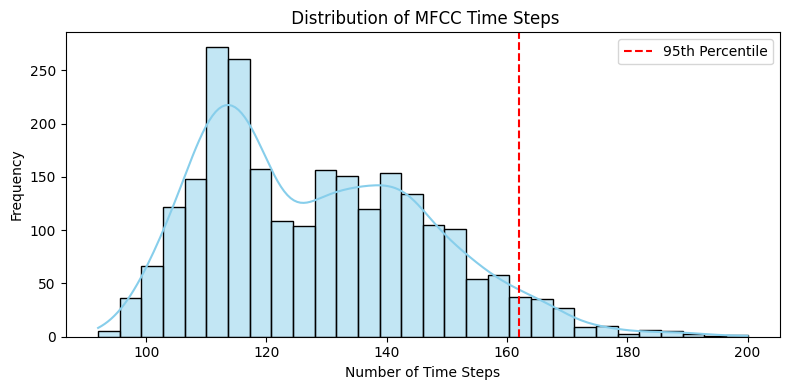

In [44]:
plt.figure(figsize=(8, 4))
sns.histplot(lengths, bins=30, kde=True, color='skyblue')
plt.axvline(np.percentile(lengths, 95), color='red', linestyle='--', label='95th Percentile')
plt.title(" Distribution of MFCC Time Steps")
plt.xlabel("Number of Time Steps")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
# 12. --- Standard Scaling ---

scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[2])
scaler.fit(X_train_flat)

X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

# Save the fitted scaler
joblib.dump(scaler, "scaler.pkl")
print(" Scaler saved to scaler.pkl")

# --- Summary ---
print("\n Preprocessing Complete")
print(f"Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}")
print(f"Labels: {len(np.unique(y_train))} classes")

 Scaler saved to scaler.pkl

 Preprocessing Complete
Train: (3432, 162, 139), Val: (368, 162, 139), Test: (367, 162, 139)
Labels: 8 classes


## Building model using 3 conv1d and 1 bilstm layer and tuning it using optuna

In [11]:
# --- Reproducibility ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# --- Data Variables ---
NUM_CLASSES = len(np.unique(y_train))
INPUT_SHAPE = (X_train_scaled.shape[1], X_train_scaled.shape[2])

# --- Class Weights ---
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# --- Model Builder Function ---
def build_model(params):
    inputs = Input(shape=INPUT_SHAPE)

    conv_reg = regularizers.l2(params['conv_l2'])
    dense_reg = regularizers.l2(params['dense_l2'])
    output_reg = regularizers.l2(params['output_l2'])

    x = Conv1D(params['conv1_filters'], kernel_size=params['kernel_size'], activation='relu', padding='same',
               kernel_regularizer=conv_reg)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=params['pool_size'])(x)
    x = SpatialDropout1D(params['conv_dropout'])(x)

    x = Conv1D(params['conv2_filters'], kernel_size=params['kernel_size'], activation='relu', padding='same',
               kernel_regularizer=conv_reg)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=params['pool_size'])(x)
    x = SpatialDropout1D(params['conv_dropout'])(x)

    x = Conv1D(params['conv3_filters'], kernel_size=params['kernel_size'], activation='relu', padding='same',
               kernel_regularizer=conv_reg)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=params['pool_size'])(x)
    x = SpatialDropout1D(params['conv_dropout'])(x)

    x = Bidirectional(LSTM(params['lstm_units'], return_sequences=False, kernel_regularizer=regularizers.l2(params['lstm_l2'])))(x)
    x = Dropout(params['dropout'])(x)

    x = Dense(params['dense_units'], activation='relu', kernel_regularizer=dense_reg)(x)
    x = Dropout(params['dropout'])(x)

    outputs = Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=output_reg)(x)

    model = Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# --- Optuna Objective Function ---
def objective(trial):
    params = {
        'conv1_filters': trial.suggest_int("conv1_filters", 32, 256, step=32),
        'conv2_filters': trial.suggest_int("conv2_filters", 32, 256, step=32),
        'conv3_filters': trial.suggest_int("conv3_filters", 64, 256, step=64),
        'kernel_size': trial.suggest_int("kernel_size", 3, 7, step=2),
        'pool_size': trial.suggest_int("pool_size", 2, 3),
        'conv_dropout': trial.suggest_float("conv_dropout", 0.1, 0.5, step=0.1),
        'lstm_units': trial.suggest_int("lstm_units", 32, 256, step=32),
        'dense_units': trial.suggest_int("dense_units", 64, 256, step=32),
        'dropout': trial.suggest_float("dropout", 0.2, 0.5, step=0.1),
        'learning_rate': trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical("batch_size", [8, 16, 32, 64]),
        'conv_l2': trial.suggest_float("conv_l2", 1e-6, 1e-2, log=True),
        'dense_l2': trial.suggest_float("dense_l2", 1e-6, 1e-2, log=True),
        'output_l2': trial.suggest_float("output_l2", 1e-6, 1e-2, log=True),
        'lstm_l2': trial.suggest_float("lstm_l2", 1e-6, 1e-2, log=True),
    }

    model = build_model(params)
    early_stop = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=0)

    model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=100,
        batch_size=params['batch_size'],
        class_weight=class_weight_dict,
        callbacks=[early_stop, TFKerasPruningCallback(trial, "val_accuracy")],
        verbose=0
    )

    val_loss, val_acc = model.evaluate(X_val_scaled, y_val, verbose=0)
    return val_acc

# --- Run Optuna ---
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=SEED))
study.optimize(objective, n_trials=200)

# --- Summary ---
print("\n Best Trial")
print("Val Accuracy:", study.best_value)
print("Best Hyperparameters:", study.best_params)

# Save best hyperparameters to a JSON file
with open("best_hyperparameters.json", "w") as f:
    json.dump(study.best_params, f, indent=4)


# --- Final Model Training on Train+Val ---
best_params = study.best_params
final_model = build_model(best_params)

X_train_full = np.concatenate([X_train_scaled, X_val_scaled])
y_train_full = np.concatenate([y_train, y_val])

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_full), y=y_train_full)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

final_model.fit(
    X_train_full, y_train_full,
    epochs=100,
    batch_size=best_params['batch_size'],
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor='accuracy', patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Final Test Evaluation ---
test_loss, test_acc = final_model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"\n Final Test Accuracy: {test_acc:.4f}")

# --- Final Train Evaluation ---
train_loss, train_acc = final_model.evaluate(X_train_full, y_train_full, verbose=1)
print(f"\n Final Train Accuracy: {train_acc:.4f}")

# --- Save Model in .h5 Format ---
final_model.save("final_optuna_cnn_lstm.h5")

# --- Classification Report ---
y_pred = np.argmax(final_model.predict(X_test_scaled, verbose=0), axis=1)

print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#  Best Trial
# Val Accuracy: 0.8260869383811951
# Best Hyperparameters: {'conv1_filters': 224, 'conv2_filters': 256, 'conv3_filters': 128, 'kernel_size': 7, 'pool_size': 2, 'conv_dropout': 0.2, 'lstm_units': 224, 'dense_units': 160, 'dropout': 0.30000000000000004, 'learning_rate': 0.00046957056735781046, 'batch_size': 16, 'conv_l2': 2.9066190293960355e-06, 'dense_l2': 2.2651597222896316e-06, 'output_l2': 0.001864475734774596, 'lstm_l2': 3.3784228553511336e-05}

[I 2025-06-23 14:49:01,405] A new study created in memory with name: no-name-6de1260b-cc93-46fa-b383-3737fc35539d
I0000 00:00:1750690142.626090      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750690142.626754      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1750690151.953397     140 cuda_dnn.cc:529] Loaded cuDNN version 90300
[I 2025-06-23 14:52:23,092] Trial 0 finished with value: 0.7744565010070801 and parameters: {'conv1_filters': 96, 'conv2_filters': 256, 'conv3_filters': 192, 'kernel_size': 5, 'pool_size': 2, 'conv_dropout': 0.1, 'lstm_units': 32, 'dense_units': 256, 'dropout': 0.4, 'learning_rate': 0.0026070247583707684, 'batch_size': 16, 'conv_l2': 5.337032762603957e-06, 'de


✅ Best Trial
Val Accuracy: 0.8260869383811951
Best Hyperparameters: {'conv1_filters': 224, 'conv2_filters': 256, 'conv3_filters': 128, 'kernel_size': 7, 'pool_size': 2, 'conv_dropout': 0.2, 'lstm_units': 224, 'dense_units': 160, 'dropout': 0.30000000000000004, 'learning_rate': 0.00046957056735781046, 'batch_size': 16, 'conv_l2': 2.9066190293960355e-06, 'dense_l2': 2.2651597222896316e-06, 'output_l2': 0.001864475734774596, 'lstm_l2': 3.3784228553511336e-05}
Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.2113 - loss: 2.0112
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4662 - loss: 1.4288
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5724 - loss: 1.1443
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6336 - loss: 0.9778
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6922 - loss: 0.8000
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7159 - loss: 0.7141
Epoch 7/1

## Final model result with visual plots

In [51]:
# Load the saved model
model = load_model("final_optuna_cnn_lstm.h5")

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

# Evaluate on full training data (if you want)
train_loss, train_acc = model.evaluate(np.concatenate([X_train_scaled, X_val_scaled]),
                                       np.concatenate([y_train, y_val]), verbose=1)
print(f"Train Accuracy: {train_acc:.4f}")

# Predict labels on test data
y_pred = np.argmax(model.predict(X_test_scaled, verbose=0), axis=1)

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8039 - loss: 1.1613
Test Accuracy: 0.8011
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9692 - loss: 0.1734
Train Accuracy: 0.9739

Classification Report:
              precision    recall  f1-score   support

       angry       0.92      0.79      0.85        57
        calm       0.87      0.84      0.85        55
     disgust       0.79      0.90      0.84        29
        fear       0.72      0.88      0.79        56
       happy       0.78      0.63      0.70        57
     neutral       0.80      0.71      0.75        28
         sad       0.73      0.79      0.76        56
    surprise       0.85      0.97      0.90        29

    accuracy                           0.80       367
   macro avg       0.81      0.81      0.81       367
weighted avg       0.81      0.80      0.80       367


Confusion Matrix:
[[45  0  5  2  1  0  1  3]
 [ 0 46  0  0  3  0  6  0]
 [ 1  1 26  0  0  0  1  0]
 [ 0  0  0 49  1  0  4  2]
 [ 3 

Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9962 - loss: 0.0589 - val_accuracy: 0.8229 - val_loss: 0.9798
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9943 - loss: 0.0597 - val_accuracy: 0.7766 - val_loss: 1.2675
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9954 - loss: 0.0604 - val_accuracy: 0.7875 - val_loss: 1.2446
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9898 - loss: 0.0690 - val_accuracy: 0.7902 - val_loss: 1.1127
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9915 - loss: 0.0738 - val_accuracy: 0.8065 - val_loss: 1.1772
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9862 - loss: 0.0915 - val_accuracy: 0.7902 - val_loss: 1.3349
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9906 - loss: 0.0738 - val_accuracy: 0.8011 - val_loss: 1.1956
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9939 - loss: 0.0653 - 

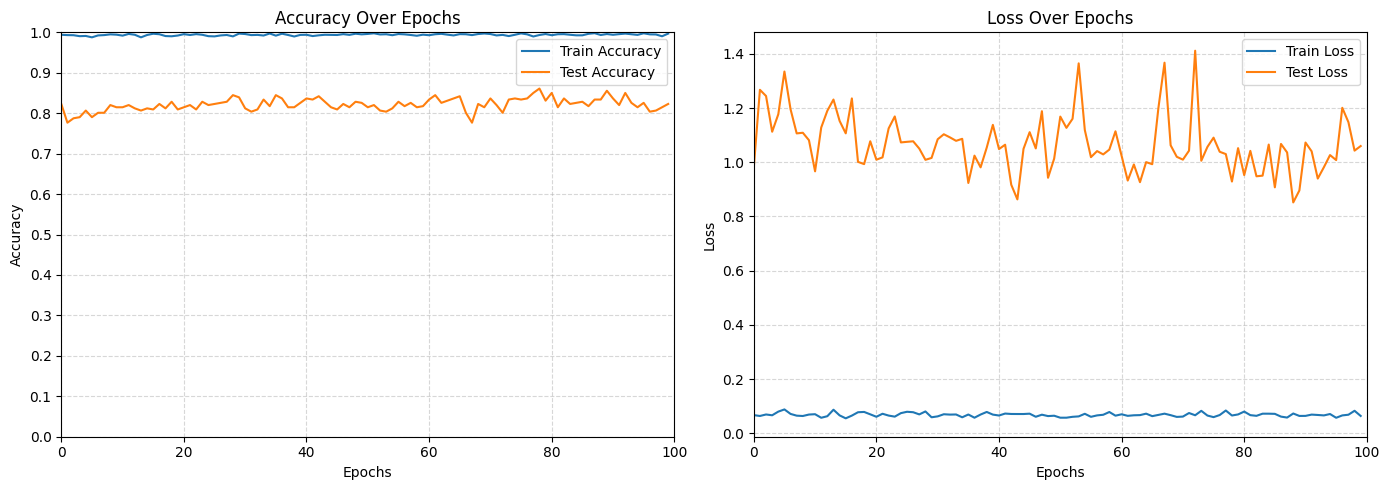

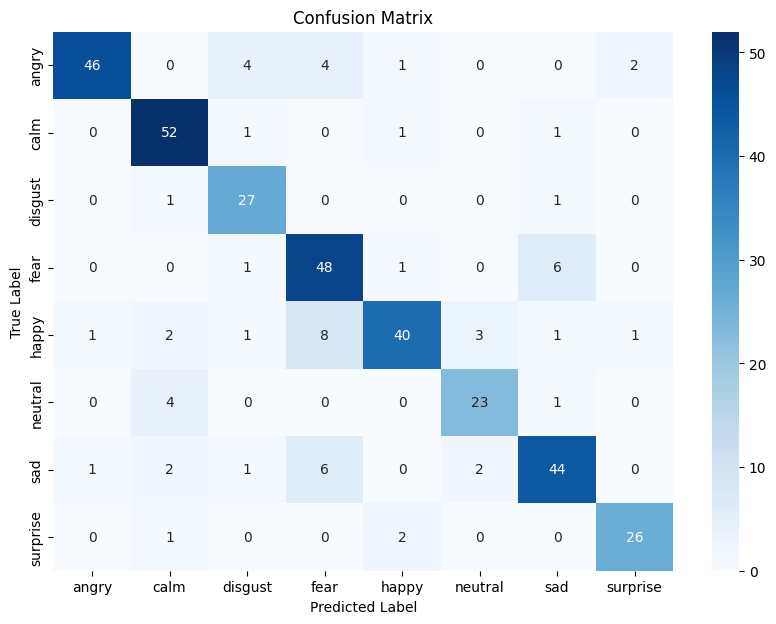

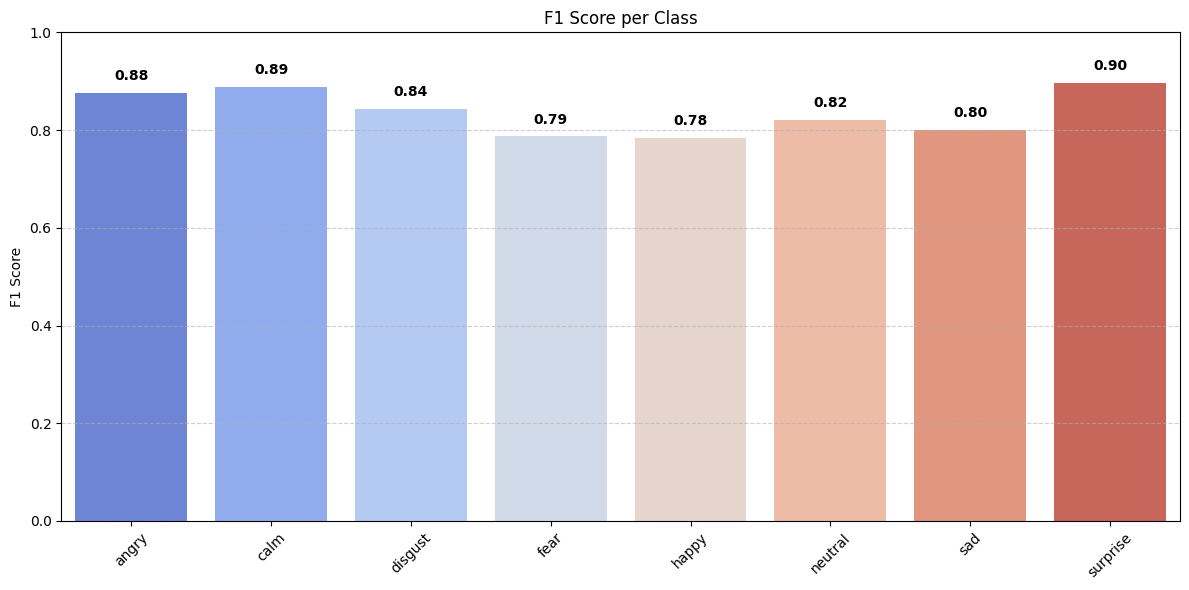

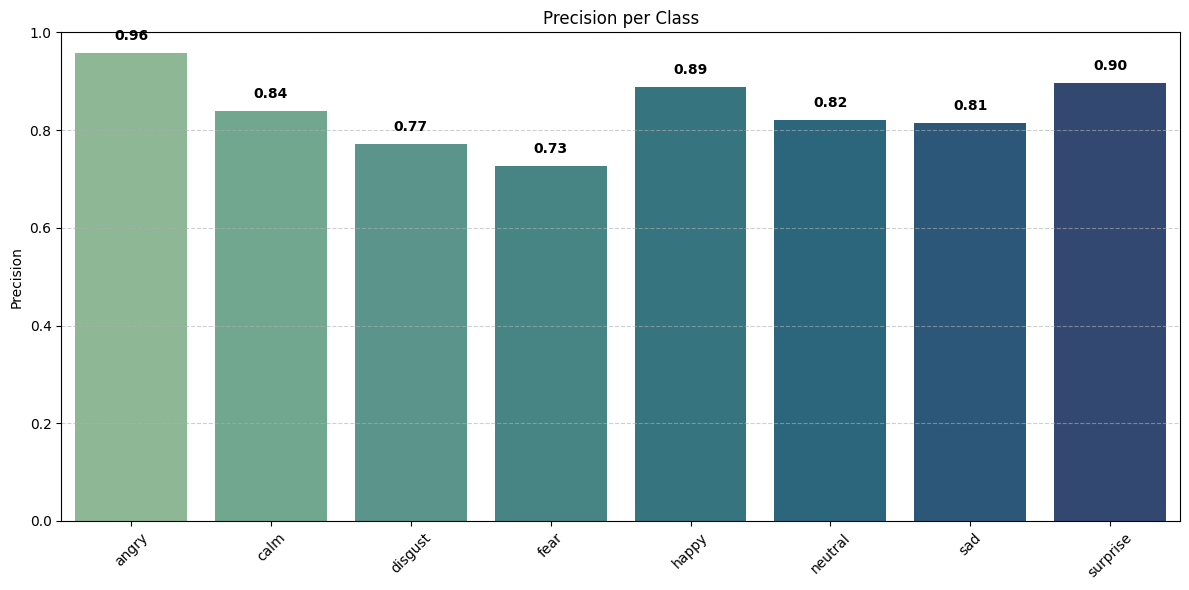

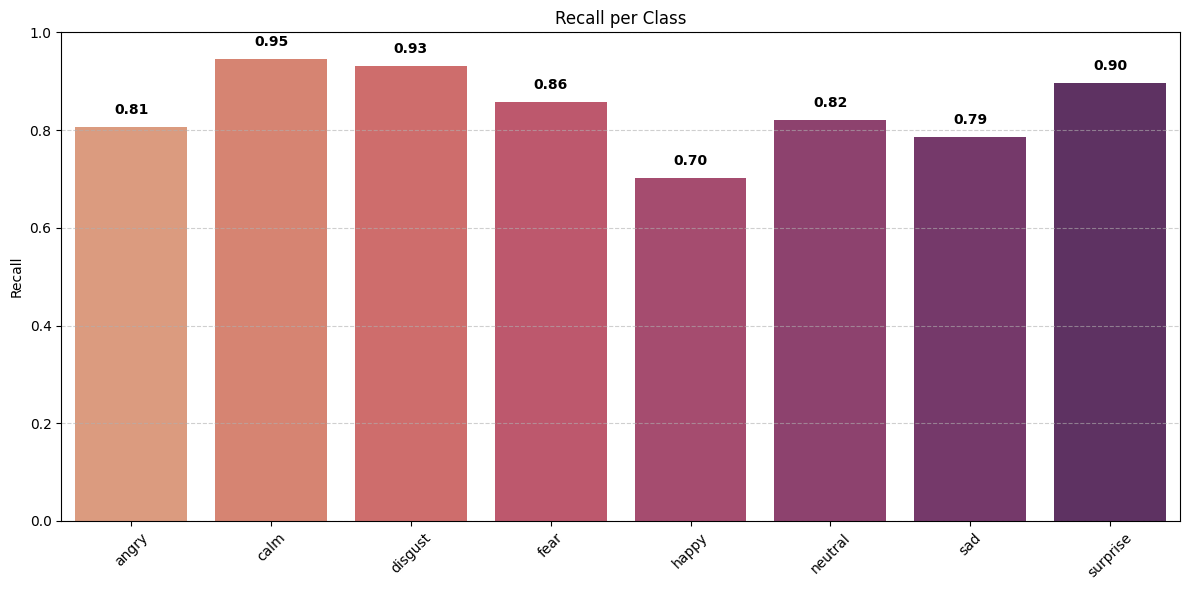

In [50]:
# -------------------------------
# 1. Training History Plot
# -------------------------------
history = final_model.fit(
    X_train_full, y_train_full,
    epochs=100,
    batch_size=best_params['batch_size'],
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor='accuracy', patience=100, restore_best_weights=True)],
    validation_data=(X_test_scaled, y_test),
    verbose=1
)

# Plot Accuracy and Loss
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.yticks([i / 10 for i in range(11)])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xlim(0, 100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

# -------------------------------
# 2. Confusion Matrix Heatmap
# -------------------------------
y_pred = np.argmax(final_model.predict(X_test_scaled, verbose=0), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Ensure predictions are made
y_pred = np.argmax(final_model.predict(X_test_scaled, verbose=0), axis=1)

# -------------------------------
# Classification Report
# -------------------------------
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

f1_scores = [report[label]['f1-score'] for label in le.classes_]
precisions = [report[label]['precision'] for label in le.classes_]
recalls = [report[label]['recall'] for label in le.classes_]

def plot_bar_metric(values, metric_name, color_palette):
    plt.figure(figsize=(12, 6))
    bars = sns.barplot(x=le.classes_, y=values, palette=color_palette)
    plt.title(f"{metric_name} per Class")
    plt.ylabel(metric_name)
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    for bar, val in zip(bars.patches, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f"{val:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Plotting the three metrics
plot_bar_metric(f1_scores, "F1 Score", "coolwarm")
plot_bar_metric(precisions, "Precision", "crest")
plot_bar_metric(recalls, "Recall", "flare")


## Checking and Saving the output files 

In [ ]:
import os
os.listdir("/kaggle/working")

In [23]:
import zipfile

files_to_zip = [
    "scaler.pkl",
    "label_encoder.pkl",
    "final_optuna_cnn_lstm.h5",
    "best_hyperparameters.json",
    "max_len.npy"
]

with zipfile.ZipFile("/kaggle/working/output_files.zip", "w") as zipf:
    for file in files_to_zip:
        zipf.write(f"/kaggle/working/{file}", arcname=file)

In [24]:
import zipfile

with zipfile.ZipFile("/kaggle/working/output_files.zip", "r") as zipf:
    print("✅ Contents of ZIP:")
    print(zipf.namelist())


✅ Contents of ZIP:
['scaler.pkl', 'label_encoder.pkl', 'final_optuna_cnn_lstm.h5', 'best_hyperparameters.json', 'max_len.npy']
